# Pima Indians Diabetes Database

# Process Description
This analysis was structured in the following steps:
1. Process and data understanding 
2. Data handling/wrangling
3. Machine Learning model implementation
4. Model Evaluation
5. Optimization/deployment
6. Conclusion

# Data Handling/wrangling

In [1]:
# Importing libraries and changing working directory
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os
%matplotlib inline
warnings.filterwarnings('ignore')
# path = r'C:\Users\casoto\Documents\GitHub\portfolio\Machine Learning Repository\Kaggle\Pima Indians Diabetes Database'
# os.getcwd(path)

In [2]:
# Reading csv file
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Checking field formats
display(data.dtypes)
print("NOTE: Data types are already correct format ('Outcome' is a boolean field but for now it will be considered int64)")

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

NOTE: Data types are already correct format ('Outcome' is a boolean field but for now it will be considered int64)


In [4]:
# Checking for missing values (NA)
display(data.isnull().any())
print("NOTE: No missing inputs, but do we have inconsistent observations in our dataset (registrations with zeros only)?")

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

NOTE: No missing inputs, but do we have inconsistent observations in our dataset (registrations with zeros only)?


In [5]:
# Statistics summary for variables
display(data.describe())
print("NOTE: In 'min' row we can see fields only with zeros. By filtering them in our dataset, we can see how many zeros we have in:\n")

for col in data.columns.tolist()[1:-1]:
    print(col + " = " + str(len(data[data[col] == 0])), end = "\n")
    
print("\nNOTE: For now, we'll leave as it is and check later if normalizing the dataset is sufficient for having a good accuracy.")    

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


NOTE: In 'min' row we can see fields only with zeros. By filtering them in our dataset, we can see how many zeros we have in:

Glucose = 5
BloodPressure = 35
SkinThickness = 227
Insulin = 374
BMI = 11
DiabetesPedigreeFunction = 0
Age = 0

NOTE: For now, we'll leave as it is and check later if normalizing the dataset is sufficient for having a good accuracy.


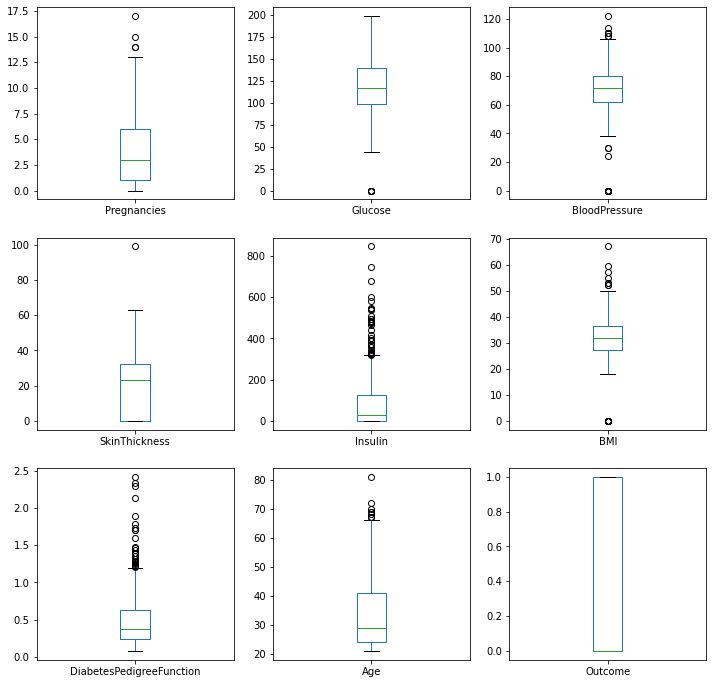

NOTE: Since we have many observations with zeros, some boxplots may be out of scale.


In [6]:
# Checking for outliers with boxplots
data.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize=(12, 12))
plt.show()
print("NOTE: Since we have many observations with zeros, some boxplots may be out of scale.")

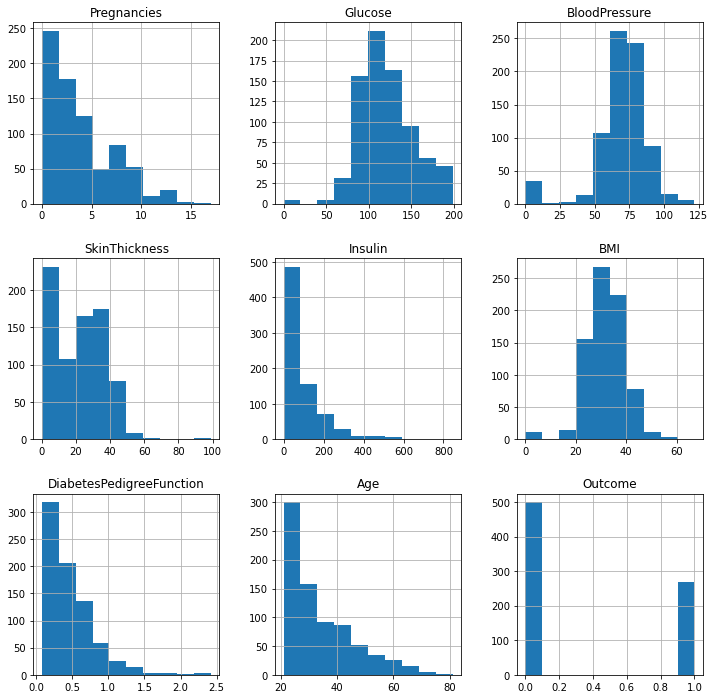

In [7]:
# Checking data distribution with histograms
data.hist(figsize=(12, 12))
plt.show()

In [8]:
# Checking data distribution for diabetes patients
display(data['Outcome'].value_counts())
print("NOTE: Data is not equally distributed between patients with and without diabetes (we have 500 cases with negative results and  268 with diabetes).")

0    500
1    268
Name: Outcome, dtype: int64

NOTE: Data is not equally distributed between patients with and without diabetes (we have 500 cases with negative results and  268 with diabetes).


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


<AxesSubplot:>

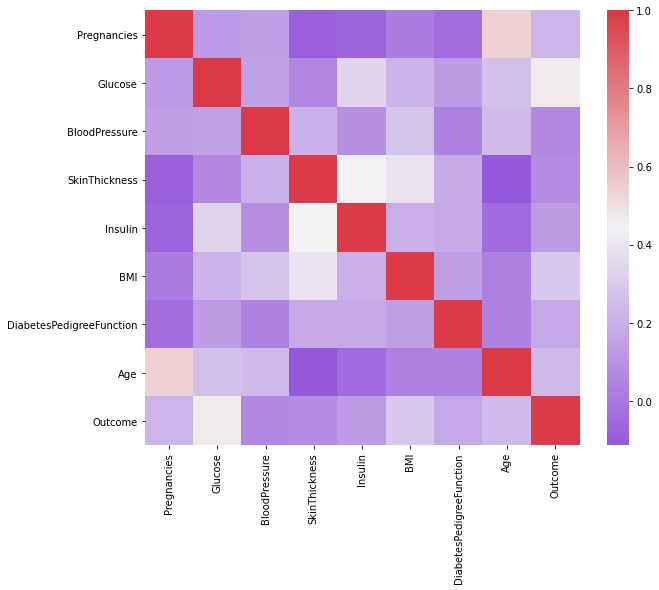

In [9]:
# Plotting correlation matrices (Pearson)
corr = data.corr()
display(corr.style.background_gradient(cmap='coolwarm').set_precision(2))
# Alternative view with heatmap
f, ax = plt.subplots(figsize=(10, 8))
display(sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(1000, 10, as_cmap=True),
            square=True, ax=ax))

### Relevant Notes
1. Data is already organised but needs to be normalized because we have different columns in different scales (i.e. 'Age' and 'Glucose'), which can be a problem when implementing our chosen model;
2. 'Outcome' column is our target variable (dependent) and all other columns are our predictors (independent); a correlation test will be useful to see if all variables should be considered in our model;
3. In the correlation matrix above, we can see some relationships between Age/Pregnancies, Skin Thickness/Insulin and Skin Thickness/BMI that can be used in the subsequent steps (for feature selection);
4. Data has been split into train and test subsets (variables X_train, Y_train, X_test and Y_test);
5. We have a classification problem (identify if a specific patient have diabetes or not), so we'll create a benchmark between three algorithms: logistic regression model, KNN (K-nearest neighbours) and random forest.

# Machine Learning model implementation

In [10]:
# Normalizing dataset using MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
array = data.values

# Separating into dependent and independent variables
X = array[:, 0:8]
Y = array[:, 8]

# Normalizing data with scaler
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(X)

# Summarizing transformed data
print("Original data: \n\n", X)
print("\nNormalized data: \n\n", rescaledX)

print("\nNOTE: For logistic regression, standard scaler was applied.")

# Using standard scaler
scaler = StandardScaler().fit(X)
standardX = scaler.transform(X)

print("\nStandarized data: \n\n", standardX)

Original data: 

 [[  6.    148.     72.    ...  33.6     0.627  50.   ]
 [  1.     85.     66.    ...  26.6     0.351  31.   ]
 [  8.    183.     64.    ...  23.3     0.672  32.   ]
 ...
 [  5.    121.     72.    ...  26.2     0.245  30.   ]
 [  1.    126.     60.    ...  30.1     0.349  47.   ]
 [  1.     93.     70.    ...  30.4     0.315  23.   ]]

Normalized data: 

 [[0.35294118 0.74371859 0.59016393 ... 0.50074516 0.23441503 0.48333333]
 [0.05882353 0.42713568 0.54098361 ... 0.39642325 0.11656704 0.16666667]
 [0.47058824 0.91959799 0.52459016 ... 0.34724292 0.25362938 0.18333333]
 ...
 [0.29411765 0.6080402  0.59016393 ... 0.390462   0.07130658 0.15      ]
 [0.05882353 0.63316583 0.49180328 ... 0.4485842  0.11571307 0.43333333]
 [0.05882353 0.46733668 0.57377049 ... 0.45305514 0.10119556 0.03333333]]

NOTE: For logistic regression, standard scaler was applied.

Standarized data: 

 [[ 0.63994726  0.84832379  0.14964075 ...  0.20401277  0.46849198
   1.4259954 ]
 [-0.84488505 -1.

In [11]:
# Splitting data into Train/Test (into 70/30 ratio)
from sklearn.model_selection import train_test_split

test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(standardX, Y, test_size = test_size)
print(f"NOTE: Training train batch size is {len(X_train)} and test is {len(X_test)}")

NOTE: Training train batch size is 537 and test is 231


In [12]:
# Creating models for Logistic Regression, KNN and Random Forest
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Defining hyperparameters for cross Validation testing
num_folds = 50
random_state = 8
kfold = KFold(num_folds, True, random_state = random_state)

# Logistic Regression
regrl = LogisticRegression()
regrl.fit(X_train, Y_train)
regrl.score(X_train, Y_train)
results = cross_val_score(regrl, X_train, Y_train, cv = kfold)
print("Accuracy (Logistic Regression): %.3f" % (results.mean() * 100))

# KNN
knn = KNeighborsClassifier()
results = cross_val_score(knn, X_train, Y_train, cv = kfold)
print("Accuracy (KNN): %.3f" % (results.mean() * 100))

# Random Forest
num_trees = 100
max_features = 8
random_forest = RandomForestClassifier(n_estimators = num_trees, max_features = max_features)
results = cross_val_score(random_forest, X_train, Y_train, cv = kfold)
print("Accuracy (Random Forest): %.3f" % (results.mean() * 100))

Accuracy (Logistic Regression): 78.091
Accuracy (KNN): 75.527
Accuracy (Random Forest): 76.818


As we can see above, after cross-validating three different Machine Learning models, Logistic regression stands out comparing with random forest and KNN algorithms, so we'll use this model for predicting our test subset.

In [13]:
# Creating model predictions with logistic regression
predicts = regrl.predict(X_test)
predicts

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0.

# Model evaluation

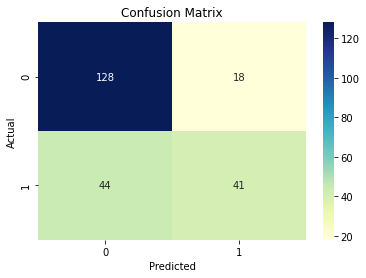

              precision    recall  f1-score   support

         0.0       0.74      0.88      0.81       146
         1.0       0.69      0.48      0.57        85

    accuracy                           0.73       231
   macro avg       0.72      0.68      0.69       231
weighted avg       0.73      0.73      0.72       231



In [14]:
# Evaluating model with confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(Y_test, predicts))
# Plotting confusion matrix
sns.heatmap(confusion_matrix, annot = True, cmap="YlGnBu" ,fmt='2g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plotting measurements for errors (Type I/False Positives and Type II/False Negatives)
print(classification_report(Y_test, predicts))

In [15]:
# Evaluating ROC (area under the curve) - values above .5 indicates good precision
result = cross_val_score(regrl, X_train, Y_train, cv = kfold, scoring = 'roc_auc')
print("AUC: %.3f" % (result.mean() * 100))

AUC: 84.122


# Optimization approaches

In [16]:
# Approach 1 - Optimizing with RFE (recursive feature elimination)
from sklearn.feature_selection import RFE

# Finding out the four best variables in our dataset
var_num = 4
vars_fit = []
vars_org = data.columns[0:8].tolist()
rfe = RFE(regrl, 4)
fit = rfe.fit(X_train, Y_train)

for e in range(len(fit.support_)):
    if fit.support_[e] == True:
        vars_fit.append(vars_org[e])
        
# Printing results
print("Variables in dataset:", data.columns[0:8].tolist())
print("Selected variables: %s" % vars_fit)
print("Features ranking: %s" % fit.ranking_)
print("Number of n features selected: %d" % fit.n_features_)

Variables in dataset: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Selected variables: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']
Features ranking: [1 1 3 5 4 1 1 2]
Number of n features selected: 4


In [17]:
# Approach 2 - Slicing dataset only with relevant variables
standardX_2 = standardX[:, list(fit.support_)]
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(standardX_2, Y, test_size = test_size)

# Re-running logistic regression model 
regrl.fit(X_train_2, Y_train_2)
regrl.score(X_train_2, Y_train_2)
results = cross_val_score(regrl, X_train_2, Y_train_2, cv = kfold)

print("Accuracy (Logistic Regression): %.3f" % (results.mean() * 100))

Accuracy (Logistic Regression): 76.418


In [18]:
# Using Random Search Parameter Tuning to evaluate parameters
from sklearn.model_selection import RandomizedSearchCV

valores_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
iterations = 14
rsearch = RandomizedSearchCV(estimator = regrl, 
                             param_distributions = valores_grid, 
                             n_iter = iterations)
rsearch.fit(X, Y)

print("Accuracy: %.3f" % (rsearch.best_score_ * 100))
print("Best parameters:\n", rsearch.best_estimator_)

Accuracy: 77.348
Best parameters:
 LogisticRegression(C=10)


# Model Deployment

In [19]:
# Exporting model into .sav file
import pickle
f = 'models/regrl_classifier.sav'
pickle.dump(regrl, open(f, 'wb'))

# # Loading .sav file
# model = pickle.load(open(f, 'rb'))

# Conclusion

In [20]:
# Recreating test dataset for visualization
predicts_df = pd.DataFrame(scaler.inverse_transform(X_test), columns = data.columns.tolist()[0:8])
predicts_df['Prediction'] = pd.Series(predicts).map(lambda x: True if x == 1 else False)
predicts_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Prediction
0,1.0,130.0,70.0,13.0,105.0,25.9,0.472,22.0,False
1,13.0,145.0,82.0,19.0,110.0,22.2,0.245,57.0,True
2,2.0,123.0,48.0,32.0,165.0,42.1,0.520,26.0,False
3,4.0,95.0,64.0,0.0,0.0,32.0,0.161,31.0,False
4,13.0,129.0,0.0,30.0,0.0,39.9,0.569,44.0,True


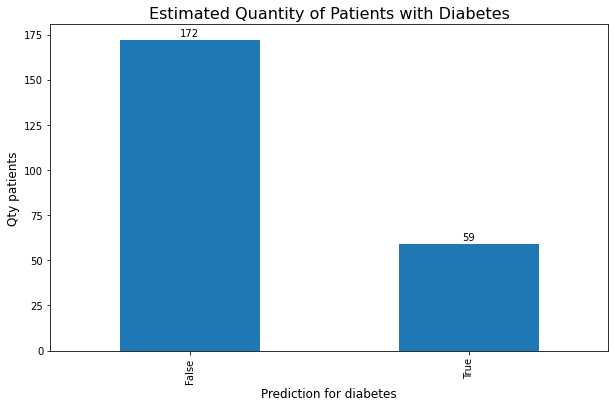

,Prediction
False,172
True,59


In [44]:
# Checking data distribution
f, ax = plt.subplots(figsize=(10, 6))

predicts_df['Prediction'].value_counts().plot(kind = "bar", align='center')
rects = predicts_df['Prediction'].value_counts().plot(kind = "bar", align='center').patches
labels = predicts_df['Prediction'].value_counts()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 1, str(label),
            ha='center', va='bottom', fontsize = 10)

plt.xlabel('Prediction for diabetes', fontsize= 12)
plt.ylabel('Qty patients', fontsize= 12)
plt.title("Estimated Quantity of Patients with Diabetes", fontsize = 16)
plt.show()

display(pd.DataFrame(predicts_df['Prediction'].value_counts()))

CONCLUSION: For the visualization above, we can see that the model predicts and separates 172 patients without diabetes and 59 positive cases. For the positive cases, we could easily filter their characteristics from the dataset and take a deeper look individually to identify further patterns for this disease.

## End